In [1]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loead dataset
df = pd.read_csv('train.csv')

In [4]:
# display the first few rows
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [6]:
# checking for missing values in each column
Missing_values = df.isnull().sum()
print(Missing_values)

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64


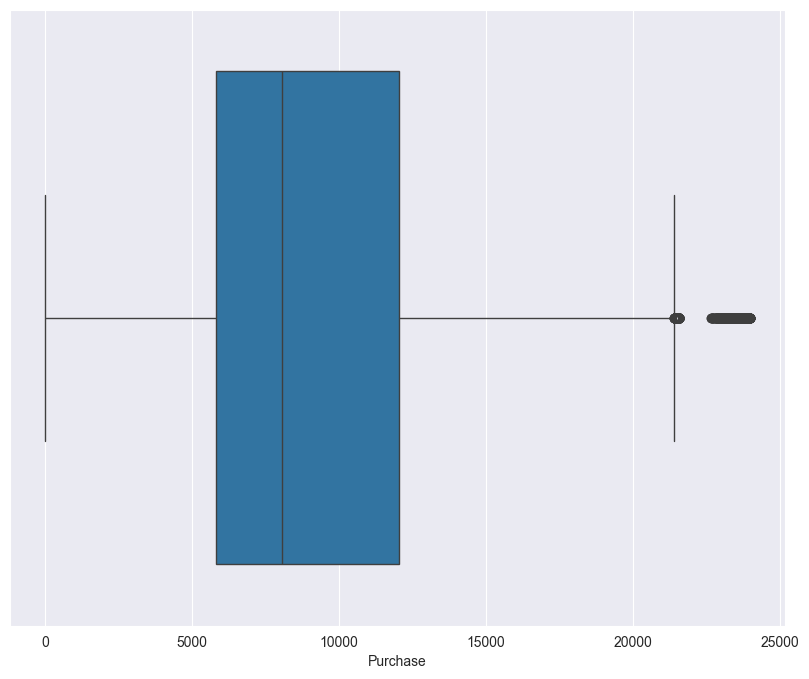

In [12]:
# identify outliers
plt.figure(figsize=(10,8))
sns.boxplot(data=df, x=df['Purchase'])
plt.show()

In [13]:
# converting Gender colomn
df['Gender'] = pd.to_numeric(df['Gender'], errors='coerce')

In [15]:
df.head

<bound method NDFrame.head of         User_ID Product_ID  Gender    Age  Occupation City_Category  \
0       1000001  P00069042     NaN   0-17          10             A   
1       1000001  P00248942     NaN   0-17          10             A   
2       1000001  P00087842     NaN   0-17          10             A   
3       1000001  P00085442     NaN   0-17          10             A   
4       1000002  P00285442     NaN    55+          16             C   
...         ...        ...     ...    ...         ...           ...   
550063  1006033  P00372445     NaN  51-55          13             B   
550064  1006035  P00375436     NaN  26-35           1             C   
550065  1006036  P00375436     NaN  26-35          15             B   
550066  1006038  P00375436     NaN    55+           1             C   
550067  1006039  P00371644     NaN  46-50           0             B   

       Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
0                               2           

In [16]:
# statistically describe
df.describe()


,User_ID,Gender,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,0.0,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,NaN,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,NaN,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,NaN,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,NaN,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,NaN,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,NaN,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,NaN,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000
